In [2]:
import pandas as pd
import numpy as np
import re #this is regex
from urllib.parse import urlparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [16]:
#Baseline Model
#Logistic Regression classifier based on lexical features
#Purpose is to compare it against my primary CNN model

#Loading validation and training datasets
train_df = pd.read_csv('training_urls_20728_Balanced.csv')
val_df = pd.read_csv('validation_urls_2592_Balanced.csv')

#Function to extract features
def extract_features(url):
  features = {}

  #parsing
  try:
    parsed_url = urlparse(url)
    domain_name = parsed_url.netloc
    path = parsed_url.path
  except:
    domain_name = ""
    path = ""

  # ----- Feature Group 1 - Length
  features['url_length'] = len(url)
  features['domain_length'] = len(domain_name)
  features['path_length'] = len(path)

  # ----- Feature group 2 - Character Counts
  features['count_dots'] = url.count('.')
  features['count_slashes'] = url.count('/')
  features['count_hyphens'] = url.count('-')
  features['count_underscore'] = url.count('_')
  features['count_equal'] = url.count('=')
  features['count_question'] = url.count('?')
  features['count_at'] = url.count('@')
  features['count_digits'] = sum(c.isdigit() for c in url)

  # ----- Feature Group 3 - Malicious Patterns
  #IP adress in domain_name
  ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
  features['is_ip'] = 1 if re.search(ip_pattern, domain_name) else 0
  #suspicious keywords
  suspicious_keywords = ['login', 'secure', 'account', 'update', 'verify', 'bank', 'signin']
  features['sus_keyword_count'] = sum(1 for word in suspicious_keywords if word in url.lower())

  return pd.Series(features)

#Feature Extraction | X is input, y is output --> this standard for ML :)
print("Extracting features...")
X_train = train_df['url'].apply(extract_features)
y_train = train_df['label']

X_val = val_df['url'].apply(extract_features)
y_val = val_df['label']

#Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#Training
baseline_model = LogisticRegression(max_iter=1000, random_state=23)
print("Training model...")
baseline_model.fit(X_train_scaled, y_train)

#evaluating results using valdation set
y_pred = baseline_model.predict(X_val_scaled)

print("\n----- Baseline Results")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

#interpreting results
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print("\nTop indicators for Phishing:")
print(feature_importance.head(3))


Extracting features...
Training model...

----- Baseline Results
Accuracy: 0.8048

Confusion Matrix:
[[1117  179]
 [ 327  969]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82      1296
           1       0.84      0.75      0.79      1296

    accuracy                           0.80      2592
   macro avg       0.81      0.80      0.80      2592
weighted avg       0.81      0.80      0.80      2592


Top indicators for Phishing:
              feature  coefficient
10       count_digits     8.181669
0          url_length     7.121351
12  sus_keyword_count     1.154091


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import string
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [5]:
#defining the model
class UrlCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_filters=64, kernel_sizes=[3, 4, 5], num_classes=1):
        super(UrlCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim,
                      out_channels=num_filters,
                      kernel_size=k) for k in kernel_sizes])

        #dropout for regularization
        self.dropout = nn.Dropout(0.5)

        #fully connected output layer
        #input: num_filters * num of different kernel sizes
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        #the shape of x is [batch_size, sequence_length]

        #embedding
        x = self.embedding(x) #[batch_size, seq_len, embed_dim]
        x = x.permute(0, 2, 1) #[batch_size, embed_dim, seq_len]

        #applying convolutions + reLU + global max pooling
        #its extracting the strongest feature map for each kernel size
        x_list = [F.relu(conv(x)) for conv in self.convs]
        x_list = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in x_list]

        x = torch.cat(x_list, 1)

        #dropout and classify
        x = self.dropout(x)
        return self.fc(x) #returning logits, so need to apply Sigmoid in training

#CONFIGURATION
#vocab_size = ?
embed_dim = 32
#num_filters = ?
kernel_sizes = [3, 4, 5]

Epoch 1/10 | Train Loss: 0.1741 | Val Loss: 0.0944 | Train Acc: 93.20% | Val Acc: 96.33%
Epoch 2/10 | Train Loss: 0.1093 | Val Loss: 0.0772 | Train Acc: 96.04% | Val Acc: 97.07%
Epoch 3/10 | Train Loss: 0.0921 | Val Loss: 0.0693 | Train Acc: 96.47% | Val Acc: 97.53%
Epoch 4/10 | Train Loss: 0.0821 | Val Loss: 0.0629 | Train Acc: 96.89% | Val Acc: 97.72%
Epoch 5/10 | Train Loss: 0.0734 | Val Loss: 0.0596 | Train Acc: 97.32% | Val Acc: 97.72%
Epoch 6/10 | Train Loss: 0.0670 | Val Loss: 0.0573 | Train Acc: 97.57% | Val Acc: 97.84%
Epoch 7/10 | Train Loss: 0.0587 | Val Loss: 0.0560 | Train Acc: 97.88% | Val Acc: 97.80%
Epoch 8/10 | Train Loss: 0.0530 | Val Loss: 0.0526 | Train Acc: 98.11% | Val Acc: 98.11%
Epoch 9/10 | Train Loss: 0.0493 | Val Loss: 0.0523 | Train Acc: 98.20% | Val Acc: 98.03%
Epoch 10/10 | Train Loss: 0.0454 | Val Loss: 0.0475 | Train Acc: 98.30% | Val Acc: 98.23%

----- CNN Final Results
              precision    recall  f1-score   support

      Benign       0.98      

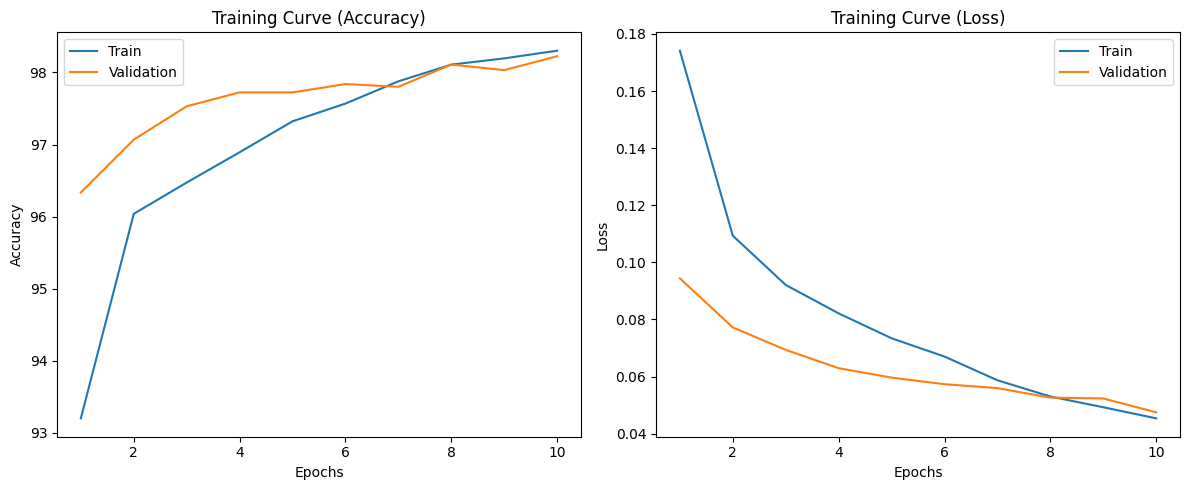

-----QUALITATIVE ANALYSIS

--- FALSE POSITIVES (safe sites flagged as phishing) (Total: 20) 
URL: http://kf.elf.stuba.sk/~slovenska_fyzikalna_spolocnost/ | Model Confidence: 88.15%
URL: http://dearbornortho.com/pages/practice.php | Model Confidence: 71.59%
URL: https://gnesin-academy.ru | Model Confidence: 72.97%
URL: https://vibsran.webs.com/ | Model Confidence: 53.34%
URL: https://reditve.com | Model Confidence: 81.58%

--- FALSE NEGATIVES (phishing sites missed) (Total: 26) 
URL: http://cd66388.tw1.ru/ | Model Confidence: 16.30%
URL: http://liteworkslighting.com/rightt/ | Model Confidence: 43.44%
URL: https://www.nacw.gov.kh/wp-admin/js/widgets/js/fi/ | Model Confidence: 24.10%
URL: https://theholistic-guides.com/ | Model Confidence: 10.01%
URL: https://matsuniversity.ac.in/club.php | Model Confidence: 26.17%

--- TRUE POSITIVES (phishing sites caught) (Total: 1270) 
URL: https://fr-programme-pickup.com/ | Model Confidence: 99.77%
URL: https://abinabinghansukuhghansyea.blogspot.com/

In [15]:
class Tokenizer:
    def __init__(self):
        self.vocab = {char: idx + 1 for idx, char in enumerate(string.printable)}
        self.vocab_size = len(self.vocab) + 1

    def encode(self, text):
        text = str(text)[:200]
        indices = [self.vocab.get(c, 0) for c in text]
        padding = [0] * (200 - len(indices))
        return indices + padding

class URLDataset(Dataset):
    def __init__(self, csv_file, tokenizer):
        self.df = pd.read_csv(csv_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        url = self.df.iloc[idx]['url']
        label = float(self.df.iloc[idx]['label'])
        encoded = self.tokenizer.encode(url)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.float), url

tokenizer = Tokenizer()
train_dataset = URLDataset('training_urls_20728_Balanced.csv', tokenizer)
val_dataset = URLDataset('validation_urls_2592_Balanced.csv', tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UrlCNN(vocab_size=tokenizer.vocab_size, num_classes=1, num_filters=128).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 10
#TRAINING LOOP
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _ in train_loader: #note _ is for url
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        #optimizer (for the training set here) updates the weights
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    #VALIDATION LOOP
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels, _ in val_loader: #note _ is for url
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            outputs = model(inputs)

            #loss for the validation data
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() #accumulating the running loss

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    #CALCULATING THE METRICS
    train_epoch_loss = running_loss / len(train_loader)
    val_epoch_loss = val_running_loss / len(val_loader)
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/10 | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels, _ in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n----- CNN Final Results")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Phishing']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


#PLOTTING
epoch_list = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.title("Training Curve (Accuracy)")
plt.plot(epoch_list, train_accuracies, label="Train")
plt.plot(epoch_list, val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')

#Loss
plt.subplot(1, 2, 2)
plt.title("Training Curve (Loss)")
plt.plot(epoch_list, train_losses, label="Train")
plt.plot(epoch_list, val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.tight_layout()
plt.show()


print("-----QUALITATIVE ANALYSIS")

#Storing examples
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []

model.eval()
with torch.no_grad():
    #unpack urls, the raw text strings
    for inputs, labels, urls in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        #Getting raw logits and probabilities
        logits = model(inputs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        #must move to cpu
        probs = probs.cpu().numpy()
        labels = labels.cpu().numpy()
        preds = preds.cpu().numpy()

        #Iterating through batch
        for i in range(len(urls)):
            url_text = urls[i]
            true_label = labels[i][0]
            pred_label = preds[i][0]
            confidence = probs[i][0]

            #sort
            item = (url_text, f"{confidence*100:.2f}%")

            if true_label == 0 and pred_label == 1:
                false_positives.append(item)
            elif true_label == 1 and pred_label == 0:
                false_negatives.append(item)
            elif true_label == 1 and pred_label == 1:
                true_positives.append(item)
            else:
                true_negatives.append(item)

#Helper function to print
def print_examples(title, examples, count=5):
    print(f"\n--- {title} (Total: {len(examples)}) ")

    for url, conf in examples[:count]:
        print(f"URL: {url} | Model Confidence: {conf}")

#printing
print_examples("FALSE POSITIVES (safe sites flagged as phishing)", false_positives, count=5)
print_examples("FALSE NEGATIVES (phishing sites missed)", false_negatives, count=5)
print_examples("TRUE POSITIVES (phishing sites caught)", true_positives, count=5)

In [24]:
#TESTING ON TEST SET (10% of URLs)

test_dataset = URLDataset('PhiUSIIL_testing_urls_2592_Balanced.csv', tokenizer)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Testing on {len(test_dataset)} samples from the testing set...")

test_y_true = []
test_y_pred = []

#eval mode
model.eval()
with torch.no_grad(): #disabling the grad calculation
    for inputs, labels, _ in test_loader: # _ is for url
        inputs = inputs.to(DEVICE)

        #forward pass
        outputs = model(inputs)

        #converting logits to a value from 0 to 1
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_y_true.extend(labels.cpu().numpy())
        test_y_pred.extend(predicted.cpu().numpy())

#FINAL RESULTS
print("\n" + "="*30)
print("FINAL TEST SET RESULTS")
print("="*30)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(test_y_true, test_y_pred)
prec = precision_score(test_y_true, test_y_pred)
rec = recall_score(test_y_true, test_y_pred)
f1 = f1_score(test_y_true, test_y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")


print("\n----- Testing Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=['Benign', 'Phishing']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_y_true, test_y_pred))

Testing on 2592 samples from the testing set...

FINAL TEST SET RESULTS
Accuracy:  0.7793
Precision: 0.9945
Recall:    0.5617
F1-Score:  0.7179

----- Testing Classification Report:
              precision    recall  f1-score   support

      Benign       0.69      1.00      0.82      1296
    Phishing       0.99      0.56      0.72      1296

    accuracy                           0.78      2592
   macro avg       0.84      0.78      0.77      2592
weighted avg       0.84      0.78      0.77      2592


Confusion Matrix:
[[1292    4]
 [ 568  728]]


In [25]:
#BASELINE MODEL TESTING ON TEST SET (10% of URLs)

test_df = pd.read_csv('PhiUSIIL_testing_urls_2592_Balanced.csv')

print("Extracting features for Baseline Model on the Test Set...")
X_test_baseline = test_df['url'].apply(extract_features)
y_test_baseline = test_df['label']

#scalling the features
X_test_baseline_scaled = scaler.transform(X_test_baseline)

#reinitializing model
baseline_model = LogisticRegression(max_iter=1000, random_state=23)

print("Retraining Baseline Model...")
baseline_model.fit(X_train_scaled, y_train)

#evaluating on the test set
y_test_pred_baseline = baseline_model.predict(X_test_baseline_scaled)

print("\n" + "="*40)
print("BASELINE MODEL RESULTS (TEST SET)")
print("="*40)
print(f"Accuracy: {accuracy_score(y_test_baseline, y_test_pred_baseline):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_baseline, y_test_pred_baseline))
print("\nClassification Report:")
print(classification_report(y_test_baseline, y_test_pred_baseline, target_names=['Benign', 'Phishing']))

Extracting features for Baseline Model on the Test Set...
Retraining Baseline Model...

BASELINE MODEL RESULTS (TEST SET)
Accuracy: 0.7542

Confusion Matrix:
[[1252   44]
 [ 593  703]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.68      0.97      0.80      1296
    Phishing       0.94      0.54      0.69      1296

    accuracy                           0.75      2592
   macro avg       0.81      0.75      0.74      2592
weighted avg       0.81      0.75      0.74      2592

